In [1]:
import netCDF4 as nc
import scipy.io as sio
import os,sys,fnmatch,time
from scipy import interpolate
import numpy as np
import numpy.ma as ma
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import cmocean as cmo

from salishsea_tools.nc_tools import scDataset
from salishsea_tools import geo_tools

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

(cmapmc, norm) = functions_plot.Colormap()
from matplotlib.colors import ListedColormap
cmapmc_r = ListedColormap(cmapmc.colors[::-1])
from matplotlib.colors import LinearSegmentedColormap
colour_list = ["#c8274c","#f25546","#F06543","#e96e33",
               "#f0b038","#FFE74C","#69b944","#72b286",
               "#69b0bc","#619ee4","#4b5bbb"][::-1]
cmapIAM = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)

# Loading observations data

In [2]:
sio.whosmat('./MackenzieTransects.mat')

[('ax', (1, 1), 'struct'),
 ('cs', (1, 1), 'struct'),
 ('stn', (1, 1), 'struct'),
 ('sts', (1, 1), 'struct')]

In [3]:
data = sio.loadmat('./MackenzieTransects.mat')

In [4]:
struct_axis = data['ax']
struct_slope = data['cs']
struct_north = data['stn']
struct_south = data['sts']

In [5]:
dtype_axis = struct_axis.dtype
dtype_slope = struct_slope.dtype
dtype_north = struct_north.dtype
dtype_south = struct_south.dtype

In [6]:
data_axis = {n: struct_axis[n][0, 0] for n in dtype_axis.names}
data_slope = {n: struct_slope[n][0, 0] for n in dtype_slope.names}
data_north = {n: struct_north[n][0, 0] for n in dtype_north.names}
data_south = {n: struct_south[n][0, 0] for n in dtype_south.names}

In [7]:
dtype_axis.names

('u', 'v', 'lat_adcp', 'lon_adcp', 'datenum_adcp', 'z', 'tsgT', 'tsgS')

In [30]:
data_south['u'].shape

(26, 1133)

In [8]:
dtype_slope.names

('num',
 'numbMMP',
 'numbCTD',
 'typ',
 'latx',
 'lonx',
 'dist',
 'z',
 'temp',
 'sal',
 'sigma',
 'datenum',
 'u',
 'v',
 'z_adcp',
 'lat_adcp',
 'lon_adcp',
 'datenum_adcp',
 'dist_adcp',
 'tsgT',
 'tsgS')

In [9]:
dtype_north.names

('num',
 'numbMMP',
 'numbCTD',
 'typ',
 'latx',
 'lonx',
 'dist',
 'z',
 'temp',
 'sal',
 'sigma',
 'datenum',
 'u',
 'v',
 'z_adcp',
 'lat_adcp',
 'lon_adcp',
 'datenum_adcp',
 'dist_adcp',
 'tsgT',
 'tsgS')

In [10]:
dtype_south.names

('num',
 'numbMMP',
 'numbSWIMS',
 'typ',
 'latx',
 'lonx',
 'dist',
 'z',
 'temp',
 'sal',
 'sigma',
 'datenum',
 'u',
 'v',
 'z_adcp',
 'lat_adcp',
 'lon_adcp',
 'datenum_adcp',
 'dist_adcp',
 'tsgT',
 'tsgS')

# Coordinates

In [11]:
obs_lat_s = data_south['latx'][0,:]
obs_lon_s = data_south['lonx'][0,:]

obs_lat_n = data_north['latx'][0,:]
obs_lon_n = data_north['lonx'][0,:]

obs_lat_p = data_slope['latx'][0,:]
obs_lon_p = data_slope['lonx'][0,:]

obs_lat_x = data_axis['lat_adcp'][0,:]
obs_lon_x = data_axis['lon_adcp'][0,:]

# Overview

In [12]:
def get_coords(dirname):
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    nav_lat = nc.Dataset(dirname)['nav_lat'][y, x]
    nav_lon = nc.Dataset(dirname)['nav_lon'][y, x]
    real = nc.Dataset(dirname)['Bathymetry'][y, x]

    return nav_lat, nav_lon, real

In [13]:
def plot_map(fig, ax, x, y, z, cmap, nav_lon, nav_lat, real):
    p = ax.pcolormesh(x, y, z, cmap=cmapmc, vmin=-1300, vmax=800)
    CS = ax.contour(nav_lon, nav_lat, real, levels = np.arange(0, 500, 20), colors='k', linestyle='-', alpha=0.5)
    for line in CS.collections:
        if line.get_linestyle() == [(None, None)]:
            pass
        else:
            line.set_linestyle([(None, None)])
            line.set_color('k')
    ax.clabel(CS, fmt='%1.1f')
    ax.legend(loc=2, fontsize=20)
    ax.set_xlim([-141, -136])
    ax.set_ylim([69.5, 71.1])
    w=1/math.cos(math.radians(70.0))
    ax.set_aspect(w)
    ax.set_ylabel('latitude [$^o$]', fontsize=20)
    ax.set_xlabel('longitude [$^o$]', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    fig.tight_layout()
    return fig, ax

In [14]:
x, y, z = functions_plot.def_regionG(xl=-141, xr=-136, yb=69.5, yt=71.1)

In [15]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/runs_with_ts/real_base/1_real_bathy_for_agrif_fix.nc'
nav_lat, nav_lon, real = get_coords(dirname)

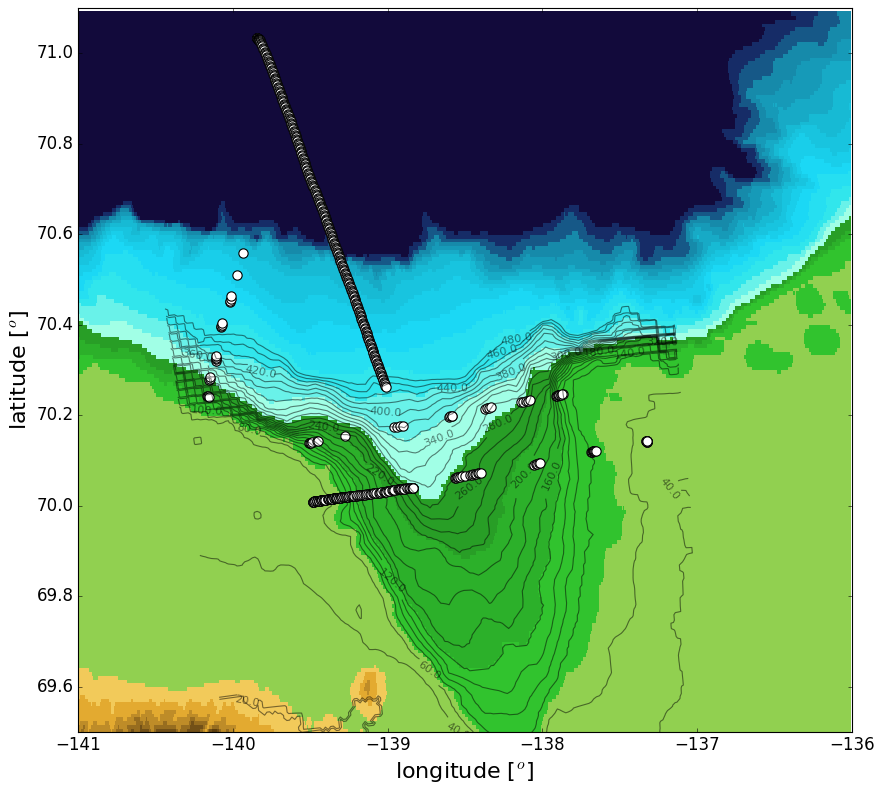

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

fig, ax = plot_map(fig, ax, x, y, z, cmapmc_r, nav_lon, nav_lat, real)

ax.scatter(obs_lon_s, obs_lat_s, c='w', s=70, edgecolors='k')
ax.scatter(obs_lon_n, obs_lat_n, c='w', s=70, edgecolors='k')
ax.scatter(obs_lon_p, obs_lat_p, c='w', s=70, edgecolors='k')
ax.scatter(obs_lon_x, obs_lat_x, c='w', s=70, edgecolors='k')